<a href="https://colab.research.google.com/github/imnaimur/cse428/blob/main/project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
from pathlib import Path
from PIL import Image

##Data preperations

In [3]:
# Install kagglehub
# !pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("briscdataset/brisc2025")
path = os.path.join(path,"brisc2025")


Using Colab cache for faster access to the 'brisc2025' dataset.


In [4]:
print("Downloaded dataset path:", path)
print("Contents:", os.listdir(path))
import os

Downloaded dataset path: /kaggle/input/brisc2025/brisc2025
Contents: ['segmentation_task', 'classification_task']


###Path setup

In [5]:
base_dir = "/content/drive/MyDrive/brisc2025"

In [6]:
import os
print("Inside base_dir:", os.listdir(path))


Inside base_dir: ['segmentation_task', 'classification_task']


###Segmentations data class

In [7]:


class BrainSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform

        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

        assert len(self.images) == len(self.masks), "Number of images and masks must match!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale mask

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


###classification data func

In [8]:
def get_classification_dataset(root_dir, transform=None):
    """
    Loads classification dataset where images are stored in class subfolders.
    Example:
        root_dir/train/glioma, meningioma, pituitary, no_tumor
    """
    return datasets.ImageFolder(root=root_dir, transform=transform)


In [ ]:
# --- transforms ---
transform_img = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor()
])

# --- Segmentation Train Loader ---
seg_train = BrainSegmentationDataset(
    images_dir=os.path.join(path, "segmentation_task/train/images"),
    masks_dir=os.path.join(path, "segmentation_task/train/masks"),
    transform=transform_img,
    target_transform=transform_mask
)
seg_train_loader = DataLoader(seg_train, batch_size=len(seg_train), shuffle=True)

# --- Classification Train Loader ---
cls_train_dataset = get_classification_dataset(
    root_dir=os.path.join(path, "classification_task/train"),
    transform=transform_img
)
cls_train_loader = DataLoader(cls_train_dataset, batch_size=len(cls_train_dataset), shuffle=True)
cls_X,cls_y = next(iter(cls_train_loader))

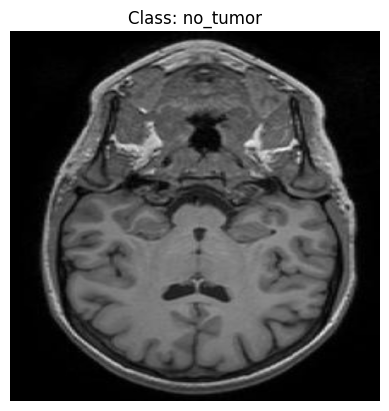

In [10]:
import random
import matplotlib.pyplot as plt

# Pick random index
idx = random.randint(0, len(cls_train_dataset) - 1)
img, label = cls_train_dataset[idx]

# Convert tensor to numpy
img_np = img.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.title(f"Class: {cls_train_dataset.classes[label]}")
plt.axis("off")
plt.show()


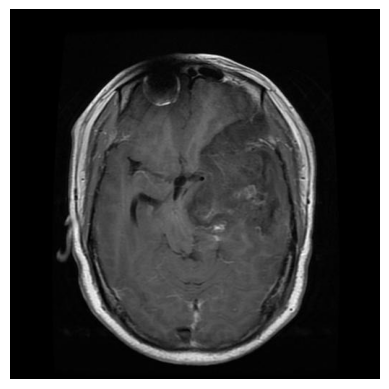

In [23]:
img = Image.open(cls_train_dataset.imgs[0][0])
plt.imshow(img)
plt.axis("off")
plt.show()